## Special_Project_Jia_Yang_Le_20010428-T415.py

#### Author: Jia Yang Le
#### Option chosen:  1: The Machine Learning Modeler
#### Topic: A curious case of whether coffee consumption alongside other health statistics could tell a person's occupation accurately
#### Created: 2025-09-16

In [1]:
# get all the packages and library ready
import argparse
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    ConfusionMatrixDisplay, 
    confusion_matrix, 
    classification_report, 
    accuracy_score
    )

from coffee_modelling import (
    preprocess_data,
    build_features_and_target,
    train_random_forest
    )                                    # own utility module for modelling 

### <u>Introduction</u>
##### Project Objective: Take a deep dive into analysing the Global Coffee Health dataset (10,000 synthetic records of adults worldwide) from Kaggle (https://www.kaggle.com/datasets/uom190346a/global-coffee-health-dataset?resource=download),  perform EDA on how coffee consumption relates to lifestyle and health attributes, and ultimately a curious case on whether these features can serve as good predictors for an individual's occupation. Hopefully after examining the correlations between different occupations and their coffee consumption alongside other health statistics, the end goal of building a multi-class classification model to predict occupation from these input variables can be realised.

##### The dataset includes attributes such as daily coffee intake, caffeine consumption, sleep duration/quality, BMI, heart rate, stress level, physical activity, health issues, and lifestyle habits (smoking, alcohol), along with demographic info (age, gender, country) and occupation. Evidently, the mentioned variables will serve as explanatory variables (X) to Occupation (Y) in the random forest model later presented.


In [2]:
csv_path = "synthetic_coffee_health_10000.csv"   
df = pd.read_csv(csv_path)               # loading the Kaggle coffee dataset 

In [3]:
df.head(5)
print('''
The dataset has 10,000 rows and 16 columns. The columns are:
ID, Age, Gender, Country, Coffee_Intake (cups/day), Caffeine_mg (mg/day), Sleep_Hours (hrs), 
Sleep_Quality, BMI, Heart_Rate, Stress_Level, Physical_Activity_Hours, Health_Issues, Occupation, 
Smoking, Alcohol_Consumption.
''')


The dataset has 10,000 rows and 16 columns. The columns are:
ID, Age, Gender, Country, Coffee_Intake (cups/day), Caffeine_mg (mg/day), Sleep_Hours (hrs), 
Sleep_Quality, BMI, Heart_Rate, Stress_Level, Physical_Activity_Hours, Health_Issues, Occupation, 
Smoking, Alcohol_Consumption.



### <u>Analysis</u>

#### Data Cleaning, Wrangling and some Feature Engineering

In [4]:
print(df.isnull().sum())
print('''
All columns show 0 missing values, so no imputation is needed.
Majority of the values in Health_Issues are "None", which is expected and shouldn't be considered as missing values 
(nonetheless, will perform ordinal encoding on Health_Issues treating the "none" properly).
Column names are already clean (no spaces or special characters), so we keep them as-is. 
''')

ID                            0
Age                           0
Gender                        0
Country                       0
Coffee_Intake                 0
Caffeine_mg                   0
Sleep_Hours                   0
Sleep_Quality                 0
BMI                           0
Heart_Rate                    0
Stress_Level                  0
Physical_Activity_Hours       0
Health_Issues              5941
Occupation                    0
Smoking                       0
Alcohol_Consumption           0
dtype: int64

All columns show 0 missing values, so no imputation is needed.
Majority of the values in Health_Issues are "None", which is expected and shouldn't be considered as missing values 
(nonetheless, will perform ordinal encoding on Health_Issues treating the "none" properly).
Column names are already clean (no spaces or special characters), so we keep them as-is. 



In [5]:
print('''
Dropping 2 columns:
We drop the ID column since it is just an identifier. 
We also decide to drop Caffeine_mg to avoid perfect collinearity with Coffee_Intake. 
Data types for numerical columns are appropriate identified as int/float, so no further wrangling on them is needed.

Moreover, no obvious data type issues were found for the categorical variables, 
however we will map ordinal categories to numeric codes. 
As such, the mentioned variables are now categorized in ordinal manners:
Sleep_Quality, Stress_Level, Health_Issues, BMI_Category, Age_Group.
In which, BMI_Category and Age_Group were categorized using pd.cut, which make the mentioned variables more memory efficient.

Lastly, Caffeine_mg and Coffee_Intake were leveraged on to create binary variable High_Caffeine_Intake where:
1 = high-caffeine-intake (>400 mg/day)
0 = non-high-caffeine-intake
''')

df_prep = preprocess_data(df)            # call saved function, save the results

cols_to_show = [
    "Sleep_Quality", "Stress_Level", "Health_Issues",
    "BMI_Category", "Age_Group", "High_Caffeine_Intake"
]
print(df_prep[cols_to_show])
print()


Dropping 2 columns:
We drop the ID column since it is just an identifier. 
We also decide to drop Caffeine_mg to avoid perfect collinearity with Coffee_Intake. 
Data types for numerical columns are appropriate identified as int/float, so no further wrangling on them is needed.

Moreover, no obvious data type issues were found for the categorical variables, 
however we will map ordinal categories to numeric codes. 
As such, the mentioned variables are now categorized in ordinal manners:
Sleep_Quality, Stress_Level, Health_Issues, BMI_Category, Age_Group.
In which, BMI_Category and Age_Group were categorized using pd.cut, which make the mentioned variables more memory efficient.

Lastly, Caffeine_mg and Coffee_Intake were leveraged on to create binary variable High_Caffeine_Intake where:
1 = high-caffeine-intake (>400 mg/day)
0 = non-high-caffeine-intake

      Sleep_Quality  Stress_Level  Health_Issues BMI_Category Age_Group  \
0                 3             1              0       Nor

#### Exploratory Data Analysis (EDA)

In [6]:
print('''
Key insights from the summary:
\033[4mNumerical variables\033[0m
Coffee Intake: Many people drink 2–3 cups daily (shown by mean of 2.51). 
A small fraction don’t consume coffee at all (0 cups) and a quarter of sample are very heavy consumers (>3.5 cups).

Sleep Hours: An interquartile range of 5.8 to 7.5 and a median ~6.6 hours shows majority of the sample size 
sleeping below the recommended 7+ hours of sleep for adults, though not too far off.

BMI: Range of 15 to around 38 shows quite the diversity. Mean of 24 is slightly at the higher end of the "Normal" category. 
Majority of the dataset have a healthy weight, with only the minority identifed as obese per their BMI.

Heart Rate: Ranges from around 70 to 109 bpm, mean around 70s, which shows majority of the sample have normal resting heart rates.

Physical Activity Hours: Range 0 to 15 hours/week, with a mean of approximately 7.5 hours/week. 
This suggests on average people get about 1 hour of exercise per day, which could indicate the sample size is overall relatively health-conscious.

\033[4mOrdinally encoded categorical variables\033[0m
Sleep Quality: More than half of the sample size rate their sleep as good, with only a minority (around 10% each tail) saying excellent or poor.

Stress Level: 70% report Low stress, ~20% Medium, ~10% High. So most of the sample size can be said to be not highly stressed.

Health Issues: Around 60% of the sample size report None, 
with 36% Mild (rather significant), ~4.6% Moderate, only ~0.17% Severe. 
Hence, severe health issues are very rare in this sample, with the majority have little-to-no chronic issues.

Smoking & Alcohol Consumption: smokers take up to 20% of the sample size while 30% of the sample size consumes alchohol.

High Caffeine Intake: 12% of the sample size are identified as having high caffeine intake (>400 mg/day). 
''')

num_summary = df_prep[["Age","Coffee_Intake","Sleep_Hours","BMI","Heart_Rate","Physical_Activity_Hours"]].describe().round(2)
display(num_summary)                                                  # mean, std, min-max, percentiles for numerical vars

for col in ["Sleep_Quality", "Stress_Level", "Health_Issues", "Smoking", "Alcohol_Consumption", "High_Caffeine_Intake"]:
    print(f"\n{df_prep[col].value_counts(normalize=True).round(2)}")  # proportions instead of raw counts for categorical vars (even tho ordinal encoded)
print()


Key insights from the summary:
Numerical variables
Coffee Intake: Many people drink 2–3 cups daily (shown by mean of 2.51). 
A small fraction don’t consume coffee at all (0 cups) and a quarter of sample are very heavy consumers (>3.5 cups).

Sleep Hours: An interquartile range of 5.8 to 7.5 and a median ~6.6 hours shows majority of the sample size 
sleeping below the recommended 7+ hours of sleep for adults, though not too far off.

BMI: Range of 15 to around 38 shows quite the diversity. Mean of 24 is slightly at the higher end of the "Normal" category. 
Majority of the dataset have a healthy weight, with only the minority identifed as obese per their BMI.

Heart Rate: Ranges from around 70 to 109 bpm, mean around 70s, which shows majority of the sample have normal resting heart rates.

Physical Activity Hours: Range 0 to 15 hours/week, with a mean of approximately 7.5 hours/week. 
This suggests on average people get about 1 hour of exercise per day, which could indicate the sample s

,Age,Coffee_Intake,Sleep_Hours,BMI,Heart_Rate,Physical_Activity_Hours
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,34.95,2.51,6.64,23.99,70.62,7.49
std,11.16,1.45,1.22,3.91,9.82,4.32
min,18.00,0.00,3.00,15.00,50.00,0.00
25%,26.00,1.50,5.80,21.30,64.00,3.70
50%,34.00,2.50,6.60,24.00,71.00,7.50
75%,43.00,3.50,7.50,26.60,77.00,11.20
max,80.00,8.20,10.00,38.20,109.00,15.00



Sleep_Quality
3    0.56
2    0.20
4    0.14
1    0.10
Name: proportion, dtype: float64

Stress_Level
1    0.7
2    0.2
3    0.1
Name: proportion, dtype: float64

Health_Issues
0    0.59
1    0.36
2    0.05
3    0.00
Name: proportion, dtype: float64

Smoking
0    0.8
1    0.2
Name: proportion, dtype: float64

Alcohol_Consumption
0    0.7
1    0.3
Name: proportion, dtype: float64

High_Caffeine_Intake
0    0.88
1    0.12
Name: proportion, dtype: float64




1. Coffee Intake vs Sleep Hours (top left)
Points are densely packed across the entire range, with a some slight tendencies to deviate towards the negatives. 
It seems like higher coffee intake might link to fewer sleep hours, 
but the relationship looks weak in the graph: wide cloud, and for any interval in coffee intake, sleep hours vary by a rather significant margin.
Therefore, we can say that coffee consumption does not strongly explain sleep duration, 
and thus neither is likely to be a discriminative feature for predicting occupation.

2. Coffee Intake by Occupation (top right)
Median coffee intake across Healthcare, Office, Other, Service, and Student groups looks very similar, all seemingly ranges from 2-3 cups a day.
The interquartile range is also close across occupations, with only minor differences.
Hence, cccupation does not appear to drive major differences in coffee intake, therefore also unlikely to serve as a strong predictor of occupation.

3. Smoking Prevalence by 

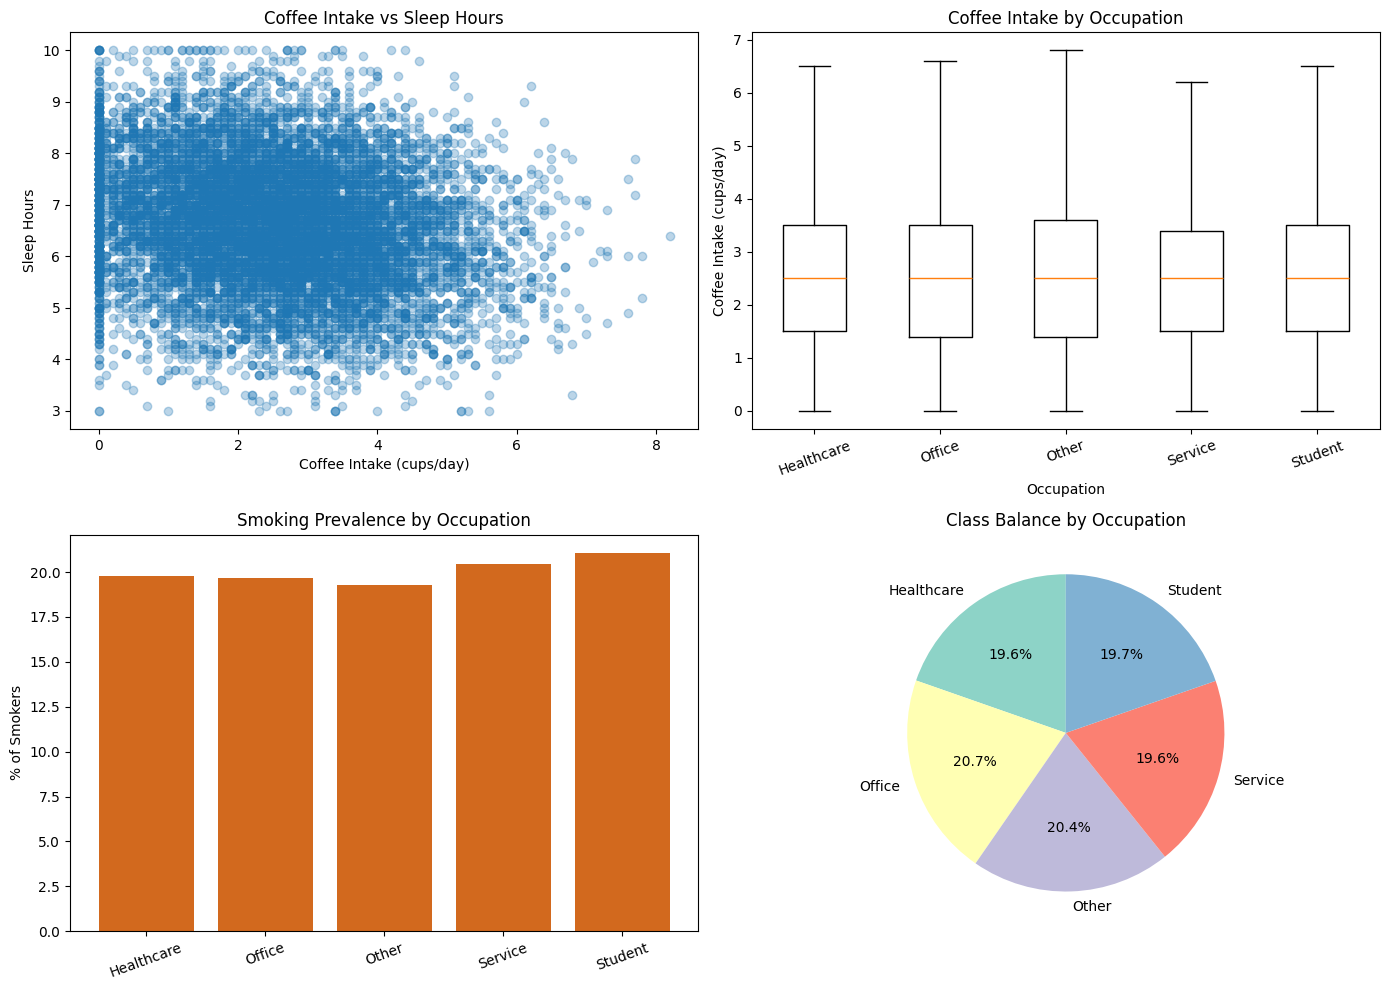

In [7]:
print('''
1. Coffee Intake vs Sleep Hours (top left)
Points are densely packed across the entire range, with a some slight tendencies to deviate towards the negatives. 
It seems like higher coffee intake might link to fewer sleep hours, 
but the relationship looks weak in the graph: wide cloud, and for any interval in coffee intake, sleep hours vary by a rather significant margin.
Therefore, we can say that coffee consumption does not strongly explain sleep duration, 
and thus neither is likely to be a discriminative feature for predicting occupation.

2. Coffee Intake by Occupation (top right)
Median coffee intake across Healthcare, Office, Other, Service, and Student groups looks very similar, all seemingly ranges from 2-3 cups a day.
The interquartile range is also close across occupations, with only minor differences.
Hence, cccupation does not appear to drive major differences in coffee intake, therefore also unlikely to serve as a strong predictor of occupation.

3. Smoking Prevalence by Occupation (bottom left)
Smoking prevalence shows little variation (close to uniform distribution) for all occupational groups, typically hovering around +-20%.
The plot shows slightly higher prevalence among Service & Students, though marginal.
Therefore we can also say Smoking does not differentiate occupation well. 

4. Class Balance by Occupation (bottom right)
The plot shows that the sample is rather balanced across occupational categories, which is good from a modeling perspective
since we can rule out potential class imbalance issues.
''')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))   # 2 rows, 2 cols to show [2x2] fig

# scatterplot - Coffee vs Sleep
axes[0,0].scatter(df_prep["Coffee_Intake"], df_prep["Sleep_Hours"], alpha=0.3)
axes[0,0].set_xlabel("Coffee Intake (cups/day)")
axes[0,0].set_ylabel("Sleep Hours")
axes[0,0].set_title("Coffee Intake vs Sleep Hours")

# boxplot - Coffee by Occupation
groups = df_prep.groupby("Occupation")["Coffee_Intake"].apply(list)
axes[0,1].boxplot(groups, tick_labels=groups.index, showfliers=False)
axes[0,1].set_xlabel("Occupation")
axes[0,1].set_ylabel("Coffee Intake (cups/day)")
axes[0,1].set_title("Coffee Intake by Occupation")
axes[0,1].tick_params(axis="x", rotation=20)

# bar chart - Smoking by Occupation
smoking_rates = df_prep.groupby("Occupation")["Smoking"].mean() * 100     # mean * 100% to get aggregated rate
axes[1,0].bar(smoking_rates.index, smoking_rates.values, color="chocolate")
axes[1,0].set_ylabel("% of Smokers")
axes[1,0].set_title("Smoking Prevalence by Occupation")
axes[1,0].tick_params(axis="x", rotation=20)

# pie chart - class balance (to inspect potential imbalance problems)
occ_share = df_prep["Occupation"].value_counts(normalize=True).sort_index() * 100
axes[1,1].pie(
    occ_share.values,
    labels=occ_share.index,
    autopct="%.1f%%",
    startangle=90,
    colors=plt.cm.Set3.colors
)
axes[1,1].set_title("Class Balance by Occupation")

plt.tight_layout()
plt.show()

#### Modelling (Random Forest)

In [8]:
X, y_enc, le = build_features_and_target(df_prep, target_col="Occupation")
model, X_train, X_test, y_train, y_test = train_random_forest(
    X, y_enc, test_size=0.2, random_state=7
)                                                                             

y_pred = model.predict(X_test)                                                     # random forest in .py file, leveraged LLM Perplexity (2025)

#### Model Evaluation and Interpretation


The accuracy on the test set came out to 20.85%, given that we have only 5 classes and they are equally represented,  
we can say that the model performed somewhat similar to what a random guess would have in the same situation.
The classification report shows each class’s precision and recall in the 0.18–0.24 range, and an F1-score around 0.19–0.22. 
This confirms that the model is barely able to significantly predict or distinguish between the 5 occupations.

The confusion matrix provides more insight into the predictions:
The values, both diagonal and off-diagonals are fairly large and spread out, indicating a lot of confusion between classes. 
For example, a true Service worker is predicted as Office or Other almost as often as correctly as Service. 
Similarly, many Students were misclassified as Office or Other, etc. 

This shows the Random Forest model is struggling to distinguish occupations from the features of coffee consumption, 
BMI, alongside all the health statistics. 
It

<Figure size 640x480 with 0 Axes>

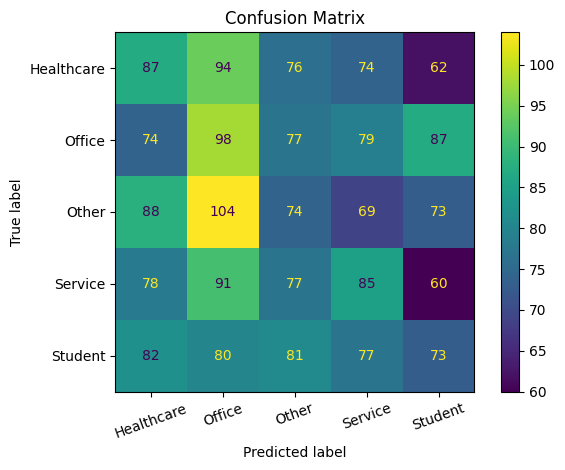

In [9]:
print('''
The accuracy on the test set came out to 20.85%, given that we have only 5 classes and they are equally represented,  
we can say that the model performed somewhat similar to what a random guess would have in the same situation.
The classification report shows each class’s precision and recall in the 0.18–0.24 range, and an F1-score around 0.19–0.22. 
This confirms that the model is barely able to significantly predict or distinguish between the 5 occupations.

The confusion matrix provides more insight into the predictions:
The values, both diagonal and off-diagonals are fairly large and spread out, indicating a lot of confusion between classes. 
For example, a true Service worker is predicted as Office or Other almost as often as correctly as Service. 
Similarly, many Students were misclassified as Office or Other, etc. 

This shows the Random Forest model is struggling to distinguish occupations from the features of coffee consumption, 
BMI, alongside all the health statistics. 
It’s predicting almost randomly across classes, indicating low discriminative power.
''')

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc*100:.2f}%")
print(classification_report(y_test, y_pred, target_names=list(le.classes_)))

# confusion matrix 
cm = confusion_matrix(y_test, y_pred, labels=range(len(le.classes_)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(le.classes_))
plt.figure()
disp.plot(values_format="d", xticks_rotation=20)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

### <u>Conclusion</u>

##### To summarize, the analysis conducted found little correlation between occupation and coffee consumption or other health metrics in the Kaggle Global Coffee Health dataset. All occupations had nearly the same distribution of coffee intake, and little-to-no differences in sleep, stress, exercise, etc. The classification model’s failure to predict occupation on an accurate manner confirms that knowing someone's coffee habit and basic health profile is not very informative of their job type (or at least for the considerably broad occupation categories in the dataset).

##### Nevertheless, meaningful takeaways can still be derived from this analysis. To start with, coffee consumption of the sample size is around 2.5 cups a day on average across all groups and there was no significant variation by occupation. We can safely say coffee is a universally consumed beverage across different jobs. Moreover, most people (around 70 percent) reported under 7 hours of sleep across all jobs, and an approximate of 10% had high stress, which was similar regardless of occupation. This might suggests some evidence that sleep deprivation and stress are common issues in modern life, regardless of the specific professions one pursues. As for physical activity hours and BMI, majority of the sample size (somewhat pleasantly suprising) met moderate exercise levels of around 7 hours per week, BMI was also in the normal range for the vast majority. Though might be worth it to note that office workers had a slightly higher overweight percentage, and service workers would tend to engage less hours in physical activites compared to other professions.

##### Just to reiterate the model performance, the random forest model could not find strong predicitve patterns which indicates chosen features such as coffee intake, stress level, BMI, age group, sleep, etc does not serve as predictors for occupation. In terms of business insights that we could potentially gain from this is that for healthcare and wellness industry players, one cannot meaningfully tailor or target specific programs based solely on occupation, since the model has potentially proven that a person's occupation are influenced by not health habits but many other social-economic factors and perhaps choices on a personal level rather than an occupational group level.

##### Lastly, it might be worth noting that this analysis used a synthetic dataset, which was likely engineered to have similar distributions across occupations to avoid bias. In reality, some occupations could have been broken down into more distinct lifestyles, for instance 9–5 office workers v.s. night-shift workers in healthcare might show significant differences in sleep patterns. 